In [1]:
import os, sys
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules.preprocessing import *
from modules.io import *
from modules.learning import *
from modules.patterns import *
from modules.statistics import *
from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from tqdm.notebook import tqdm
import seaborn
import pickle
from timeit import default_timer as timer
plt.style.use('ggplot')

# Detect with static yaw with a different approach (regression that fits best)

# Load Data

In [2]:
turbine = 'BEBEZE01'
dataset_file = f'/data/data2/engie_initial/post_treated_data/BEZ/{turbine}_scada_high_frequency.parquet'
df = load_df(dataset_file)
df = df.dropna(axis=1, how='all')
df.columns = df.columns.str.replace('cor. ', '', regex=False)

In [3]:
cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
        'nacelle direction', 'wind direction']
df = df[cols]

# Resample and apply filters

In [4]:
df.head()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction
datetime,,,,,,
2018-01-03 00:00:00,11.272275,3.650000,15.220119,1936.342041,180.116089,175.347885
2018-01-03 00:00:02,10.005727,3.886307,15.229703,1992.992554,180.116089,186.393020
2018-01-03 00:00:04,10.507183,4.122613,15.239287,2022.112915,180.116089,187.452170
2018-01-03 00:00:06,10.704224,4.358920,15.248871,2027.170776,180.116089,188.673038
2018-01-03 00:00:08,10.312802,4.595226,15.258455,2015.790172,180.116089,189.826151


In [5]:
def outliers_IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df >(Q3 + 1.5 * IQR))).any(axis=1)]
    return df_iqr

# Resample with 60second granularity
df=change_granularity(df,granularity='1min')

df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
df["theta_d"][df["theta_d"] > +180] -= 360
df["theta_d"][df["theta_d"] < -180] += 360
df["theta_d"] = df["theta_d"].rolling(60).mean()
df = df.dropna()

df_initial = df.copy()

# Perform IQR outlier removal
df = outliers_IQR(df)
print(df.shape)

# drop values of wind speed under 5m/s
df=filter_col(df, 0, less_than=5, bigger_than=11)

# drop values with pitch angle higher than 2 degrees or lower than -2 degrees
df=filter_col(df, 1, less_than=-2, bigger_than=2)

# drop values of rotor speed under 8rpm
df=filter_col(df, 2, less_than=8, bigger_than=15)

# drop values of power near the power_limit and near or below zero
power_limit = 2050
df=filter_col(df, 4, less_than=1e-4, bigger_than= None)



#filter dynamic yaw
#df=filter_col(df, -1, less_than=-1, bigger_than= 1)

# Keep only dates with lidar measurements
start = '2018-06-02'
end = '2019-01-11'
df = filter_dates(df, start, end)
print(df.info())

Resample Complete
Groupping Complete
Chunk Interpolate Done
Interpolate Complete
(467354, 7)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124656 entries, 2018-06-02 00:00:00 to 2019-01-10 00:17:00
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   wind speed         124656 non-null  float64
 1   pitch angle        124656 non-null  float64
 2   rotor speed        124656 non-null  float64
 3   active power       124656 non-null  float64
 4   nacelle direction  124656 non-null  float64
 5   wind direction     124656 non-null  float64
 6   theta_d            124656 non-null  float64
dtypes: float64(7)
memory usage: 7.6 MB
None


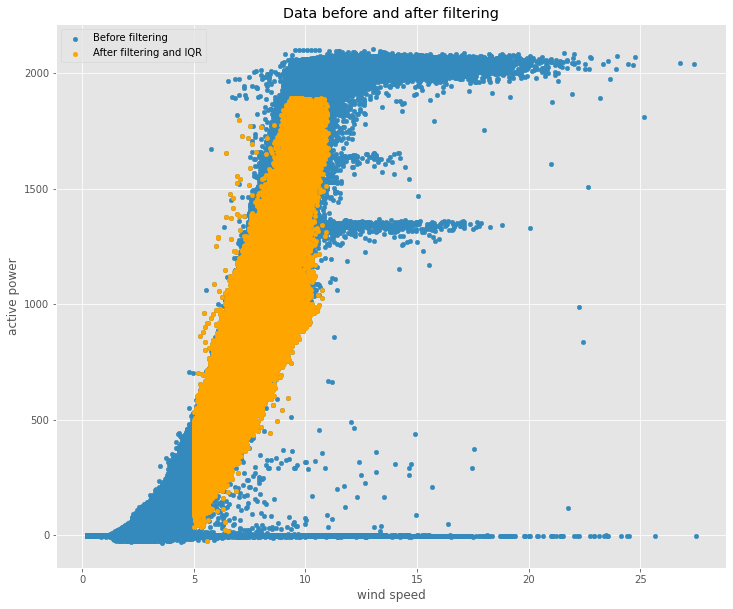

In [6]:
ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering and IQR')
plt.title("Data before and after filtering")
plt.show()

# Print statistics

In [7]:
df.describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
count,124656.000000,124656.000000,124656.000000,124656.000000,124656.000000,124656.000000,124656.000000
mean,6.763843,0.168098,11.251889,624.512066,193.353065,192.250312,-0.121741
std,1.233358,0.334237,1.604458,351.481551,85.870647,81.686552,5.423069
min,5.000011,-0.000151,8.117171,-23.678705,0.116119,5.023190,-16.270431
25%,5.748228,0.000000,10.340955,347.312956,157.107240,156.836826,-3.141363
50%,6.551961,0.000000,10.728808,542.221980,199.871918,198.527721,-0.012138
75%,7.595057,0.141264,12.267076,834.051242,245.969391,245.062400,2.944259
max,10.999597,1.999586,14.999959,1892.253299,359.039842,357.732339,16.397973


# Print correlations

In [8]:
df.corr()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,theta_d
wind speed,1.000000,0.648972,0.642809,0.878007,-0.005969,0.008422,0.020152
pitch angle,0.648972,1.000000,0.161915,0.647320,-0.032169,-0.023964,0.022394
rotor speed,0.642809,0.161915,1.000000,0.799637,0.009544,0.023976,0.048611
active power,0.878007,0.647320,0.799637,1.000000,-0.019491,-0.004563,0.044110
nacelle direction,-0.005969,-0.032169,0.009544,-0.019491,1.000000,0.912057,-0.225788
wind direction,0.008422,-0.023964,0.023976,-0.004563,0.912057,1.000000,-0.181526
theta_d,0.020152,0.022394,0.048611,0.044110,-0.225788,-0.181526,1.000000


# Remove outliers using the iQR method and Local Outlier Factor

In [9]:
def outliers_LoF(df):
    clf = LocalOutlierFactor(n_neighbors=300, n_jobs=16)
    res = clf.fit_predict(df)
    df = df[res == 1]
    return df


In [10]:
df_outliers = df.copy()
df = outliers_LoF(df).copy()
print(df.shape)

(122701, 7)


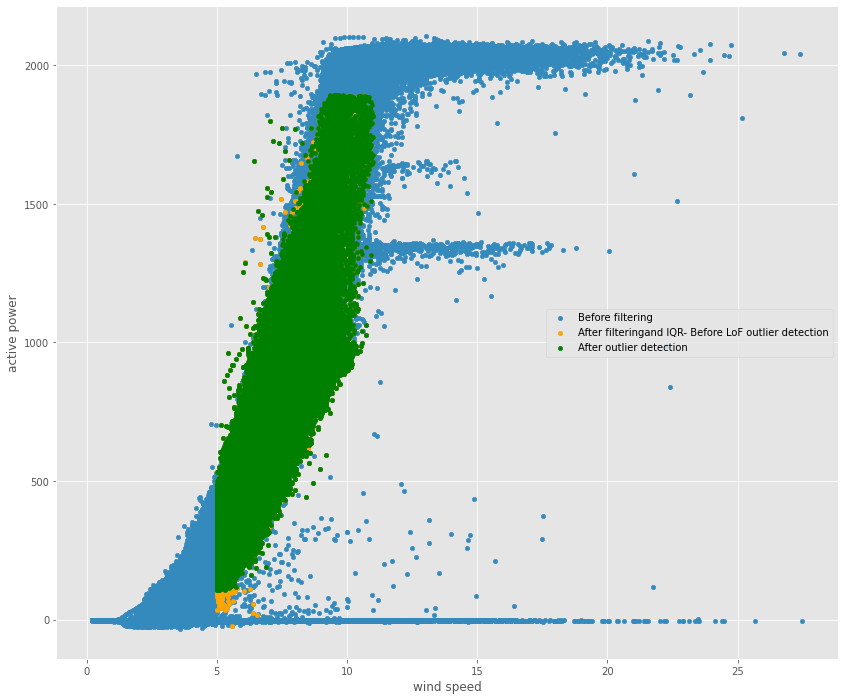

In [11]:
ax1 = df_initial.plot.scatter(x='wind speed', y='active power', figsize=(14, 12), label='Before filtering')
ax1 = df_outliers.plot.scatter(ax =ax1, x='wind speed', y='active power', c='orange', figsize=(14, 12), label='After filteringand IQR- Before LoF outlier detection')
df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='green', label = 'After outlier detection')
plt.show()

# Add a column with the measured static yaw misalignment

BEBEZE01


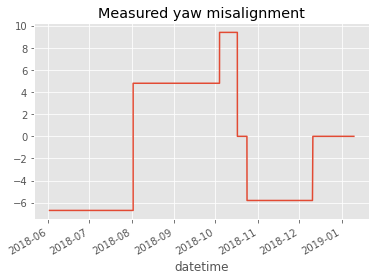

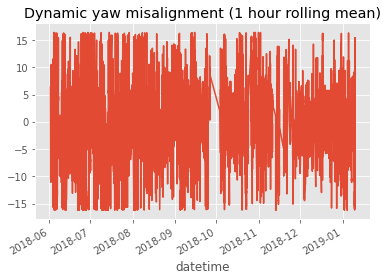

In [12]:
df["y"] = np.nan
m1 = (df.index >= '2018-10-17') & (df.index < '2018-10-24')
m2 = (df.index >= '2018-12-11')
date_masks = [(df.index < '2018-08-02'),
              (df.index >= '2018-08-02') & (df.index < '2018-10-04'),
              (df.index >= '2018-10-04') & (df.index < '2018-10-17'),
              (df.index >= '2018-10-17') & (df.index < '2018-10-24'),
              (df.index >= '2018-10-24') & (df.index < '2018-12-11'),
              (df.index >= '2018-12-11')]

if turbine == 'BEBEZE01':
    print(turbine)
    static_misalignment_values = [-6.7, 4.8, 9.4, 0, -5.8, 0] # BBZ1
elif turbine == 'BEBEZE02':
    print(turbine)
    static_misalignment_values = [2.7, 2.7, 4.9, 0, -5.1, 0] # BBZ2
elif turbine == 'BEBEZE03':
    print(turbine)
    static_misalignment_values = [-2.2, 3.4, 7.5, 0, -5.5, 0] # BBZ3

for m, s in zip(date_masks, static_misalignment_values):
    df.loc[m, 'y'] = s
df['y'].plot()
plt.title("Measured yaw misalignment")
plt.show()

df['theta_d'].plot()
plt.title("Dynamic yaw misalignment (1 hour rolling mean)")
plt.show()

### Split dataset into bins based on wind speed

In [13]:
bin_size = 0.5
min_speed = 5
max_speed = 11
bins = np.arange(min_speed, max_speed, bin_size)
bins = np.append(bins,max_speed)
print(bins)
bin_masks = []
bin_feature = 'wind speed'
for i in range(len(bins) - 1):
    mask = (df[bin_feature]>= bins[i]) & (df[bin_feature] < bins[i + 1])
    bin_masks.append(mask)

[ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11. ]


### Perform a simple feature selection before using lasso regression

In [14]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

df_scaled = scale_df(df.copy())
features = ['wind speed', 'pitch angle', 'rotor speed', 'nacelle direction', 'wind direction', 'theta_d']
target = 'active power'
X = df_scaled[features]
y = df_scaled[target]
lasso = Lasso(alpha=0.01).fit(X, y)
print(lasso.coef_)
model = SelectFromModel(estimator=lasso, prefit=True)
sup = model.get_support()
selected_features = list(np.array(features)[sup])
print(f'The selected features are: {selected_features}')

[ 0.39812315  0.02329426  0.25908982 -0.         -0.          0.        ]
The selected features are: ['wind speed', 'pitch angle', 'rotor speed']


### Perform a grid search in order to find the best parameters for the regression model

In [15]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from modules.preprocessing import enumerate2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(mape1, greater_is_better=False)

def perform_grid_search(df, feats, target):
    df_x = df[feats]
    df_y = df[target]
    X = df_x.values
    y = df_y.values
    linear_regression = Ridge()
    polynomial_features = PolynomialFeatures()
    

    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("ridge_regression", linear_regression)])
    parameters = {'ridge_regression__alpha':[0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                  'polynomial_features__degree':list(range(1,13))}
    grid_pipeline = GridSearchCV(pipeline, parameters, verbose=0, n_jobs=-1, pre_dispatch=64, scoring=scorer).fit(X, y)
    deg = grid_pipeline.best_params_['polynomial_features__degree']
    a = grid_pipeline.best_params_['ridge_regression__alpha']
    return a, deg
    
fit_features = selected_features
target_feature = 'active power'
# gc = True
# if gc == True:
#     alpha_list = []
#     degree_list = []
#     for f in tqdm(np.linspace(0.001, 0.05, 5)):
#         for it in range(10):
#             alpha, degree = perform_grid_search(df_scaled.sample(frac=f), fit_features, target_feature)
#             alpha_list.append(alpha)
#             degree_list.append(degree)
#     degree = np.round(np.mean(degree_list)).astype(int)
#     alpha = np.mean(alpha_list)
# else:
#     degree = 8
#     alpha = 0.006
# print(degree, alpha)

### Train models. 
- For each wind speed bin for each misalignment angle

In [16]:
df_scaled['y'] = df['y']

models_dict = {}
models_scores_dict = {}
binned_data_dfs = []
bin_feature = 'wind speed'

for b in bin_masks:
    df_temp = df_scaled[b]
    binned_data_dfs.append(df_temp.copy())
static_misalignment_values1 = [x for i, x in enumerate(static_misalignment_values) if i != 4]
for theta_s in np.unique(static_misalignment_values1):
    print(f"Train models for theta_s = {theta_s}")
    models = []
    preds = []
    mape_list = []
    train_mape_list = []
    mae_list = []
    fit_features = selected_features
    target_feature = ['active power']
    start = timer()
    for bin_n, d in enumerate(binned_data_dfs):
        d = d[d['y'] == theta_s].copy()
        if d.shape[0] >= 100:
            df_train = d.sample(frac=0.8,random_state=1)
            df_test = d.drop(df_train.index)
            alpha, degree = perform_grid_search(df_train, fit_features, target_feature)
            model, y_pred, r_sq, mae, me, mape, mpe = fit_linear_model(df_train, fit_features, target_feature, a=alpha, deg=degree, method='ridge')
            train_mape_list.append(mape)
            test_preds = predict(df_test, model, fit_features, target_feature)
            r_sq, mae, me, mape, mpe = score(df_test[target_feature].values, test_preds)
            models.append(model)
            preds.append(test_preds)
            mape_list.append(mape)
            mae_list.append(mae)
        else:
            models.append(None)
            preds.append(None)
    end = timer()
    print(f'Time to tune and train: {(end - start):.3} sec')
    avg_mape = np.mean(mape_list)
    avg_train_mape = np.mean(train_mape_list)
    avg_mae = np.mean(mae_list)
    print(f"Average train MAPE for theta_s {theta_s}: {avg_train_mape}")
    print(f"Average Test MAPE for theta_s {theta_s}: {avg_mape}")
    models_dict[str(theta_s)] = models
    models_scores_dict[str(theta_s)] = avg_mape

print("Save models...")
with open('trained_models_selected.pickle', 'wb') as file:
    pickle.dump(models_dict, file, protocol=pickle.HIGHEST_PROTOCOL)
    

Train models for theta_s = -6.7
Time to tune and train: 7.4 sec
Average train MAPE for theta_s -6.7: 0.06044663007366437
Average Test MAPE for theta_s -6.7: 0.06649263914978235
Train models for theta_s = 0.0
Time to tune and train: 4.77 sec
Average train MAPE for theta_s 0.0: 0.050196486057136544
Average Test MAPE for theta_s 0.0: 0.053998485740716994
Train models for theta_s = 4.8
Time to tune and train: 7.43 sec
Average train MAPE for theta_s 4.8: 0.047890273075268684
Average Test MAPE for theta_s 4.8: 0.05063732571563401
Train models for theta_s = 9.4
Time to tune and train: 4.47 sec
Average train MAPE for theta_s 9.4: 0.040702667389666096
Average Test MAPE for theta_s 9.4: 0.04632434903778628
Save models...
